In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM')


from src.RL_functions.generate_synthetic_time_series import *
from pytagi.hybrid_test_AGVI import AGVI_SSM
import matplotlib.pyplot as plt
import numpy as np


## Generate synthetic time series with LL and AR_auto

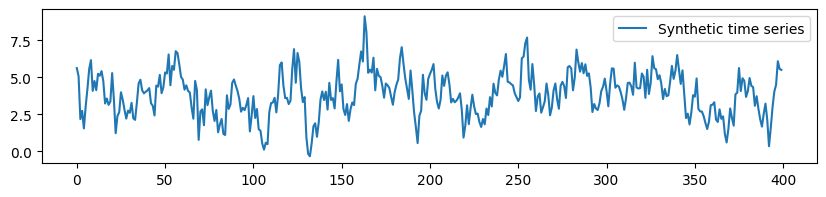

In [2]:
components = ['level', 'ar']
hyperparameters = {'level': {'process_error_var': 0.0},
                   'ar': {'phi': 0.75, 'process_error_var': 1**2},
                #    'ar': {'phi': 0.75, 'process_error_var': 0**2},
                   'observation': {'error': 1e-20}}
x_init = {'mu': np.array([4,  -0.05]), \
          'var': np.diag([1E-15, 6.36E-05])}

total_time_steps = int(400)
time_step_interval = 1
np.random.seed(2024)

syn_ts = generate_time_series(components = components,\
                                      time_step = time_step_interval, \
                                      hyperparameters = hyperparameters,\
                                      num_steps = total_time_steps, \
                                      x_init = x_init,\
                                      insert_anomaly = False)

from matplotlib import gridspec
fig = plt.figure(figsize=(10, 2))
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])

ax0.plot(syn_ts['timesteps'], syn_ts['y'], label='Synthetic time series', alpha=1)
ax0.legend()

# Train BDLM to find the sigma_AR

In [3]:
# # Autoregressive acceleration + online AR
hybrid = AGVI_SSM(
    baseline = 'level + AR', # 'level', 'trend', 'acceleration', 'ETS'
    zB  = np.array([4, 0.15, -0.05]),    # First-order-regression baseline
    SzB = np.array([1e-20, 0.5**2, 1**2]),    # var
    # baseline = 'level + AR_AGVI', # 'level', 'trend', 'acceleration', 'ETS'
    # zB  = np.array([4, -0.05]),    # First-order-regression baseline
    # SzB = np.array([1e-20, 0.5**2]),    # var
    # baseline = 'AR_AGVI', # 'level', 'trend', 'acceleration', 'ETS'
    # zB  = np.array([-0.05]),    # First-order-regression baseline
    # SzB = np.array([0.5**2]),    # var
    use_auto_AR = True,
    mu_W2b_init = 2**2,
    var_W2b_init = 1**2,
)

mu_x = hybrid.z
var_x = hybrid.Sz
mu_sigma_ar = []
var_sigma_ar = []
mu_phi_ar = []
var_phi_ar = []
mu_y = []
var_y = []

hybrid.init_ssm_hs()
for n in range(total_time_steps):
    # Feed forward
    y_pred, _, z_pred, Sz_pred = hybrid(mu_x, var_x)
    # Backward
    hybrid.backward(mu_obs = syn_ts['y'][n], var_obs = 1e-20)

    mu_sigma_ar.append(np.sqrt(hybrid.mu_W2b_posterior.item()))
    var_sigma_ar.append(np.sqrt(hybrid.var_W2b_posterior))
    mu_phi_ar.append(hybrid.z[-2].item())
    var_phi_ar.append(hybrid.Sz[-2, -2])
    mu_y.append(hybrid.mu_y_pred[-1].item())
    var_y.append(hybrid.var_y_pred[-1].item())

Text(0, 0.5, 'observation')

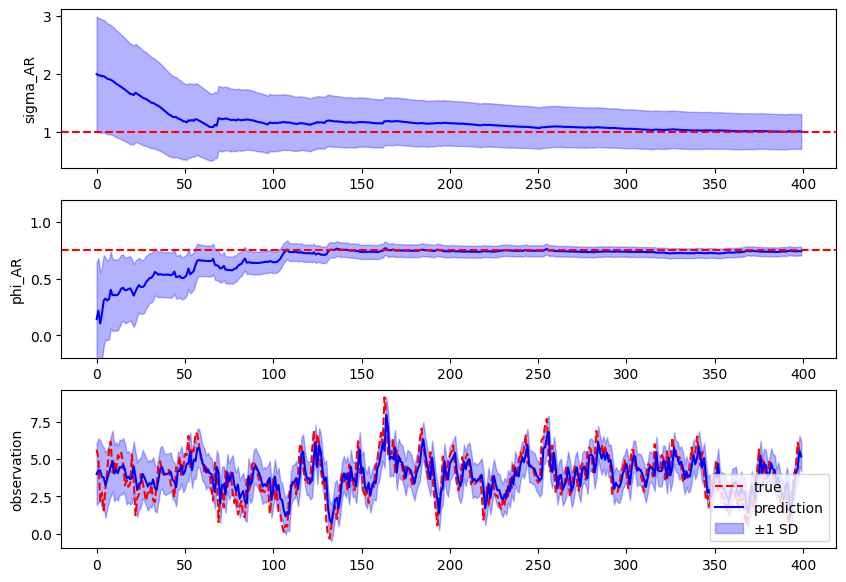

In [4]:
fig = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(3, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
# plt.plot(np.arange(len(mu_aa)),mu_aa,color='b',label=r"AR")
# plt.fill_between(np.arange(len(mu_aa)), np.array(mu_aa) - np.sqrt(var_aa), np.array(mu_aa) + np.sqrt(var_aa), color='blue', alpha=0.3, label='±1 SD')
ax0.plot(np.arange(len(mu_sigma_ar)),mu_sigma_ar,color='b',label=r"AR")
ax0.fill_between(np.arange(len(mu_sigma_ar)), np.array(mu_sigma_ar) - np.sqrt(var_sigma_ar), np.array(mu_sigma_ar) + np.sqrt(var_sigma_ar), color='blue', alpha=0.3, label='±1 SD')
ax0.axhline(y=np.sqrt(hyperparameters['ar']['process_error_var']), color='r', linestyle='--', label='True sigma_AR')
ax0.set_ylabel('sigma_AR')

ax1.plot(np.arange(len(mu_phi_ar)),mu_phi_ar,color='b',label=r"AR")
ax1.fill_between(np.arange(len(mu_phi_ar)), np.array(mu_phi_ar) - np.sqrt(var_phi_ar), np.array(mu_phi_ar) + np.sqrt(var_phi_ar), color='blue', alpha=0.3, label='±1 SD')
ax1.axhline(y=hyperparameters['ar']['phi'], color='r', linestyle='--', label='True phi')
ax1.set_ylim(-0.2, 1.2)
ax1.set_ylabel('phi_AR')

ax2.plot(np.arange(len(mu_y)),syn_ts['y'],'--',color='r',label=r"true")
ax2.plot(np.arange(len(mu_y)),mu_y,color='b',label=r"prediction")
ax2.fill_between(np.arange(len(mu_y)), np.array(mu_y) - np.sqrt(var_y), np.array(mu_y) + np.sqrt(var_y), color='blue', alpha=0.3, label='±1 SD')
ax2.legend(loc = 'lower right')
ax2.set_ylabel('observation')
